In [1]:
#本章需导入的模块
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn import tree
import sklearn.linear_model as LM
from sklearn import ensemble
from sklearn.datasets import make_classification,make_circles,make_regression
from sklearn.metrics import zero_one_loss,r2_score,mean_squared_error,accuracy_score
import xgboost as xgb

In [2]:
data=pd.read_excel('北京市空气质量数据.xlsx')
data=data.replace(0,np.NaN)
data=data.dropna()
X=data.iloc[:,3:-1]
Y=data['质量等级']
Y=Y.map({'优':'1','良':'2','轻度污染':'3','中度污染':'4','重度污染':'5','严重污染':'6'})
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.70, random_state=123)

B=300
dt_stump = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=1)
TestErrAdaB=np.zeros((B,))
adaBoost = ensemble.AdaBoostClassifier(base_estimator=dt_stump,n_estimators=B,random_state=123)
adaBoost.fit(X_train,Y_train)
for b,Y_pred in enumerate(adaBoost.staged_predict(X_test)):
    TestErrAdaB[b]=zero_one_loss(Y_test,Y_pred) 

TestErrGBRT=np.zeros((B,))
GBRT=ensemble.GradientBoostingClassifier(loss='deviance',n_estimators=B,max_depth=3,min_samples_leaf=1,random_state=123)
GBRT.fit(X_train,Y_train)
for b,Y_pred in enumerate(GBRT.staged_predict(X_test)):
    TestErrGBRT[b]=zero_one_loss(Y_test,Y_pred) 

TestErrBag=np.zeros((B,)) 
TestErrRF=np.zeros((B,))
for b in np.arange(B):
    Bag=ensemble.BaggingClassifier(base_estimator=dt_stump,n_estimators=b+1,oob_score=True,random_state=123,bootstrap=True)
    Bag.fit(X_train,Y_train)
    TestErrBag[b]=1-Bag.score(X_test,Y_test)
    RF=ensemble.RandomForestClassifier(max_depth=3,n_estimators=b+1,oob_score=True,random_state=123,
                                       bootstrap=True,max_features="auto")
    RF.fit(X_train,Y_train)
    TestErrRF[b]=1-RF.score(X_test,Y_test)


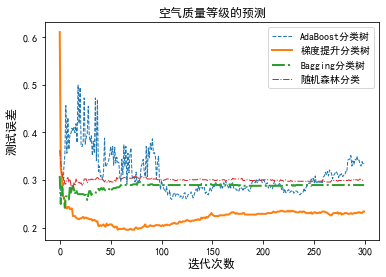

In [3]:
plt.figure(figsize=(6,4))
plt.plot(np.arange(B),TestErrAdaB,linestyle='--',label="AdaBoost分类树",linewidth=1)
plt.plot(np.arange(B),TestErrGBRT,linestyle='-',label="梯度提升分类树",linewidth=2)
plt.plot(np.arange(B),TestErrBag,linestyle='-.',label="Bagging分类树",linewidth=2)
plt.plot(np.arange(B),TestErrRF,linestyle='-.',label="随机森林分类",linewidth=1)
plt.title("空气质量等级的预测",fontsize=12)
plt.xlabel("迭代次数",fontsize=12)
plt.ylabel("测试误差",fontsize=12)
plt.legend()   

说明：基于空气质量监测数据，采用集成学习的不同策略预测空气质量等级，并进行对比。 1、首先利用旁置法划分训练集和测试集。 2、以树深度等于3的分类树作为集成学习器，分别建立基于提升策略的分类树和梯度提升分类树，并计算迭代次数增加至300过程中的测试误差。 3、分别采用袋装策略和随机森林建立分类模型，并计算迭代次数增加至300过程中的测试误差。 4、对计算结果绘制折线图。图形显示，梯度提升树的测试误差最低，预测效果最为理想。

In [10]:
Xtrain=np.array(X_train)
Ytrain=np.array(Y_train)
Xtest=np.array(X_test)
Ytest=np.array(Y_test)
modelXGB=xgb.XGBClassifier(max_depth=3,learning_rate=1, n_estimators=B,objective='multi:softmax',random_state=123)
modelXGB.fit(Xtrain,Ytrain,eval_set=[(Xtrain, Ytrain), (Xtest, Ytest)],verbose=True)
result=modelXGB.evals_result()
#print(accuracy_score(Ytrain,modelXGB.predict(Xtrain)))
#print(1-zero_one_loss(Ytest,modelXGB.predict(Xtest)))   

[0]	validation_0-merror:0.20791	validation_1-merror:0.22417
[1]	validation_0-merror:0.20109	validation_1-merror:0.22893
[2]	validation_0-merror:0.18200	validation_1-merror:0.22099
[3]	validation_0-merror:0.16905	validation_1-merror:0.22099
[4]	validation_0-merror:0.16769	validation_1-merror:0.20986
[5]	validation_0-merror:0.16155	validation_1-merror:0.21145
[6]	validation_0-merror:0.15065	validation_1-merror:0.22258
[7]	validation_0-merror:0.14383	validation_1-merror:0.22417
[8]	validation_0-merror:0.14179	validation_1-merror:0.22258
[9]	validation_0-merror:0.13838	validation_1-merror:0.22258
[10]	validation_0-merror:0.12747	validation_1-merror:0.22258
[11]	validation_0-merror:0.12406	validation_1-merror:0.21622
[12]	validation_0-merror:0.12202	validation_1-merror:0.21781
[13]	validation_0-merror:0.11588	validation_1-merror:0.20986
[14]	validation_0-merror:0.10293	validation_1-merror:0.20827
[15]	validation_0-merror:0.10498	validation_1-merror:0.20509
[16]	validation_0-merror:0.09612	v

[134]	validation_0-merror:0.00000	validation_1-merror:0.22893
[135]	validation_0-merror:0.00000	validation_1-merror:0.22734
[136]	validation_0-merror:0.00000	validation_1-merror:0.22734
[137]	validation_0-merror:0.00000	validation_1-merror:0.22576
[138]	validation_0-merror:0.00000	validation_1-merror:0.22734
[139]	validation_0-merror:0.00000	validation_1-merror:0.23053
[140]	validation_0-merror:0.00000	validation_1-merror:0.22893
[141]	validation_0-merror:0.00000	validation_1-merror:0.22893
[142]	validation_0-merror:0.00000	validation_1-merror:0.22734
[143]	validation_0-merror:0.00000	validation_1-merror:0.23053
[144]	validation_0-merror:0.00000	validation_1-merror:0.23053
[145]	validation_0-merror:0.00000	validation_1-merror:0.23211
[146]	validation_0-merror:0.00000	validation_1-merror:0.23211
[147]	validation_0-merror:0.00000	validation_1-merror:0.22893
[148]	validation_0-merror:0.00000	validation_1-merror:0.22893
[149]	validation_0-merror:0.00000	validation_1-merror:0.22893
[150]	va

[267]	validation_0-merror:0.00000	validation_1-merror:0.23211
[268]	validation_0-merror:0.00000	validation_1-merror:0.23053
[269]	validation_0-merror:0.00000	validation_1-merror:0.23211
[270]	validation_0-merror:0.00000	validation_1-merror:0.23211
[271]	validation_0-merror:0.00000	validation_1-merror:0.23211
[272]	validation_0-merror:0.00000	validation_1-merror:0.23211
[273]	validation_0-merror:0.00000	validation_1-merror:0.23211
[274]	validation_0-merror:0.00000	validation_1-merror:0.23211
[275]	validation_0-merror:0.00000	validation_1-merror:0.23370
[276]	validation_0-merror:0.00000	validation_1-merror:0.23211
[277]	validation_0-merror:0.00000	validation_1-merror:0.23053
[278]	validation_0-merror:0.00000	validation_1-merror:0.23211
[279]	validation_0-merror:0.00000	validation_1-merror:0.23211
[280]	validation_0-merror:0.00000	validation_1-merror:0.23053
[281]	validation_0-merror:0.00000	validation_1-merror:0.23053
[282]	validation_0-merror:0.00000	validation_1-merror:0.23053
[283]	va

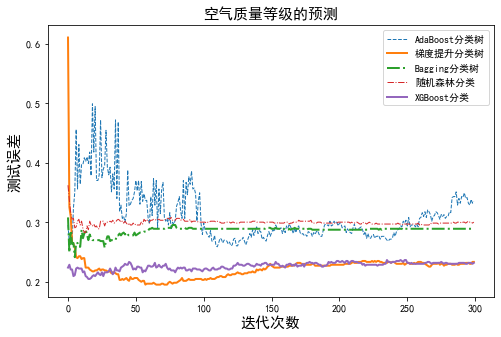

In [11]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(B),TestErrAdaB,linestyle='--',label="AdaBoost分类树",linewidth=1)
plt.plot(np.arange(B),TestErrGBRT,linestyle='-',label="梯度提升分类树",linewidth=2)
plt.plot(np.arange(B),TestErrBag,linestyle='-.',label="Bagging分类树",linewidth=2)
plt.plot(np.arange(B),TestErrRF,linestyle='-.',label="随机森林分类",linewidth=1)
plt.plot(np.arange(B),result['validation_1']['merror'],linestyle='-',label="XGBoost分类",linewidth=2)
plt.title("空气质量等级的预测",fontsize=15)
plt.xlabel("迭代次数",fontsize=15)
plt.ylabel("测试误差",fontsize=15)
plt.legend()   

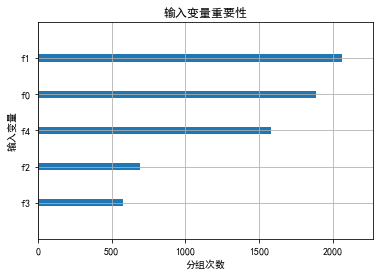

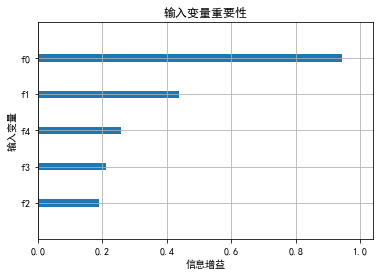

In [12]:
xgb.plot_importance(modelXGB,title="输入变量重要性",ylabel="输入变量",xlabel="分组次数",importance_type="weight",show_values=False)
xgb.plot_importance(modelXGB,title="输入变量重要性",ylabel="输入变量",xlabel="信息增益",importance_type="gain",show_values=False)